# Build and train a ANN model for time series data

Author: Robin Baumann

## Import and Load Dependencies

In [1]:
%%capture

# Load TensorFlow and shwo versions
!pip install tensorflow==2.5
import tensorflow as tf

# Load Tensorflow optimizations
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

# Load TensorFlow Lites C converter
!pip install
from tensorflow.lite.python.util import convert_bytes_to_c_source

# Numpy 
!pip install numpy
import numpy as np

# Matplotlib 
!pip install matplotlib
import matplotlib.pyplot as plt

# Python's math library
!pip install math
import math

# Define paths to model files
!pip install os
import os
!pip install shutil
import shutil

In [2]:
# Print tensorflow versions
print('TF Version', tf.__version__)
print('Keras Version', tf.keras.__version__)

TF Version 2.5.0
Keras Version 2.5.0


In [3]:
# Clear backend and set random seeds for reproducability
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

## Configure directories

In [4]:
# Folder for all Models
MODELS_DIR = 'models/'
if os.path.exists(MODELS_DIR):
    shutil.rmtree(MODELS_DIR)
os.mkdir(MODELS_DIR)

# Folder for all Data
DATA_DIR = 'data/'
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
os.mkdir(DATA_DIR)

# Tensorboard logs
LOG_DIR = 'logs/'
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.mkdir(LOG_DIR)
    
# Directorys for Models
MODEL_NAME = 'time_series_model_ann'
MODEL_TF = MODELS_DIR + MODEL_NAME
MODEL_KERAS = MODEL_TF + '.h5'
MODEL_TF_QUANT = MODELS_DIR + MODEL_NAME + '_quant'
MODEL_KERAS_QUANT = MODEL_TF_QUANT + '.h5'
MODEL_TFLITE = MODELS_DIR + MODEL_NAME + '.tflite'
MODEL_TFLITE_HEADER = MODELS_DIR + MODEL_NAME + '.h'
MODEL_TFLITE_QUANT = MODELS_DIR + MODEL_NAME + '_quant.tflite'
MODEL_TFLITE_HEADER_QUANT = MODELS_DIR + MODEL_NAME + '_quant.h'

## Dataset

### 1. Generate Data

#### Sunspot Data

In [5]:
# # import wget to load Data
# !pip install wget
# import wget

# # Get Test Dataset
# fielname = wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv', out=DATA_DIR)

# # import Dependencie to handel csv files
# import csv

# # Read Data from zip
# time_step = []
# sunspots = []
# with open(fielname) as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     sunspots.append(float(row[2]))
#     time_step.append(int(row[0]))

# # Define Data
# time = np.array(time_step)
# true_values = np.array(sunspots)

# # define Inputs
# input_1 = true_values.copy()
# for t in range(len(input_1)):
#   input_1[t] += 0.1 * input_1[t - 10]
#   input_1[t] += 0.8 * input_1[t - 2]
# input_1 = input_1*42

# input_2 = true_values.copy()
# input_2 +=  max(input_2)*np.cos(time*np.pi)
# input_2 = input_2+42.2

#### Sinus Example

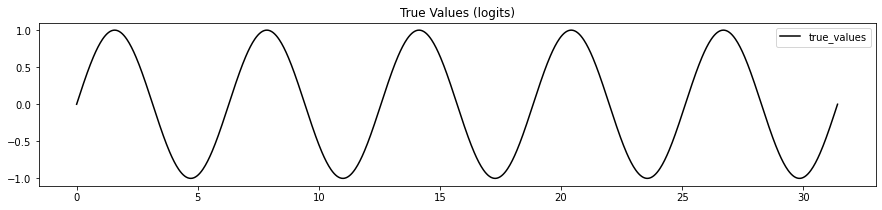

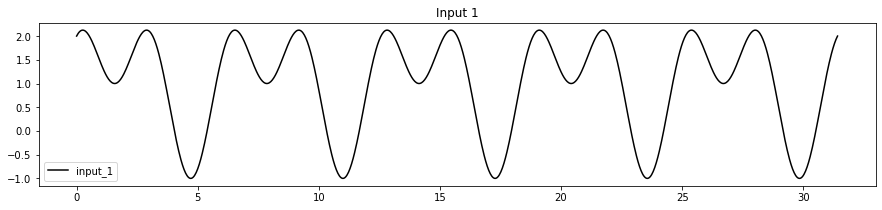

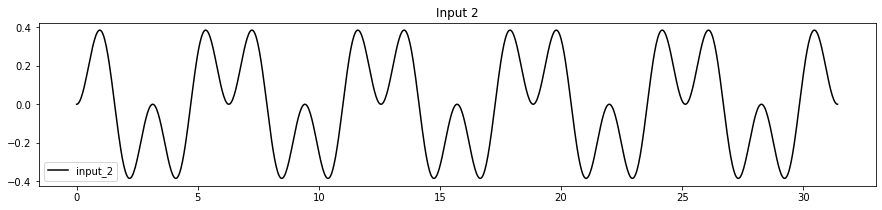

In [6]:
# Create time vector for a Period of 10 pi
time = np.linspace(0, 10*np.pi, num=1000)

# Create sinus for time interval (with noise)
true_values = np.sin(time)

# Create cos as inputs for network (with noise)
input_1 = np.sin(time)+2*np.cos(time)**2
#input_1 += 0.05 * np.random.randn(*input_1.shape)
input_2 = np.sin(time)**2*np.cos(time)
#input_2 += 0.05 * np.random.randn(*input_2.shape)

# Plot the data
# True data
plt.figure(figsize=(15,3))
plt.title('True Values (logits)')
plt.plot(time, true_values, 'k-', label="true_values")
plt.legend()
plt.show()

# input_1
plt.figure(figsize=(15,3))
plt.title('Input 1')
plt.plot(time, input_1, 'k-', label="input_1")
plt.legend()
plt.show()
# input_2
plt.figure(figsize=(15,3))
plt.title('Input 2')
plt.plot(time, input_2, 'k-', label="input_2")
plt.legend()
plt.show()

### 2. Normalize the Data

In [7]:
# Get Range of data and Normalize the data
VALUES_RANGE = round(max(true_values)-min(true_values), 3)
VALUES_MEAN = round(np.mean(true_values), 3)
true_values = (true_values-VALUES_MEAN)/VALUES_RANGE

INPUT_1_RANGE = round(max(input_1)-min(input_1), 3)
INPUT_1_MEAN = round(np.mean(input_1), 3)
input_1 = (input_1-INPUT_1_MEAN)/INPUT_1_RANGE

INPUT_2_RANGE = round(max(input_2)-min(input_2), 3)
INPUT_2_MEAN = round(np.mean(input_2), 3)
input_2 = (input_2-INPUT_2_MEAN)/INPUT_2_RANGE

# calculate step size
STEP_SIZE = time[1]-time[0]

# Print Values
print('VALUES_RANGE: ', VALUES_RANGE)
print('VALUES_MEAN: ', VALUES_MEAN)
print('INPUT_1_RANGE: ', INPUT_1_RANGE)
print('INPUT_1_MEAN: ', INPUT_1_MEAN)
print('INPUT_2_RANGE: ', INPUT_2_RANGE)
print('INPUT_2_MEAN: ', INPUT_2_MEAN)
print('STEP_SIZE: ', STEP_SIZE)

VALUES_RANGE:  2.0
VALUES_MEAN:  -0.0
INPUT_1_RANGE:  3.125
INPUT_1_MEAN:  1.001
INPUT_2_RANGE:  0.77
INPUT_2_MEAN:  0.0
STEP_SIZE:  0.03144737390980774


### 3. Split the Data and Create Datasets


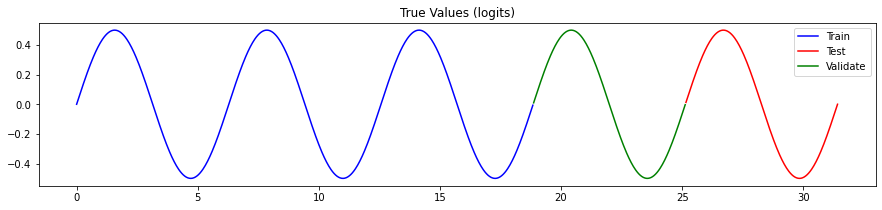

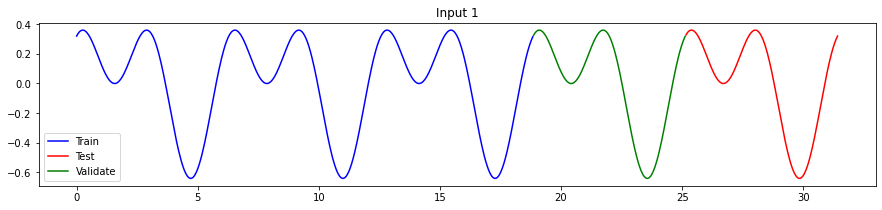

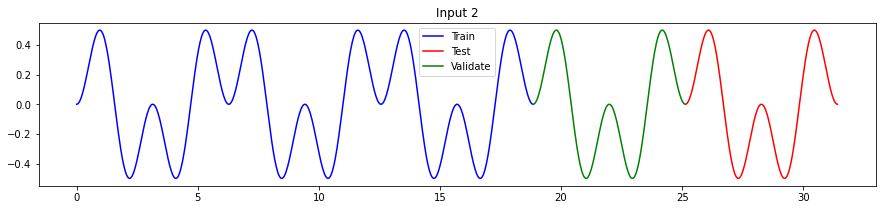

In [8]:
# 60% of our data for training and 20% for testing, remaining 20% for validation
train_split =  int(0.6 * len(time))
test_split = int(0.2*len(time) + train_split)

# Use np.split to chop data into three parts.
# True data
time_train, time_validate, time_test = np.split(time, [train_split,test_split])
true_values_train, true_values_validate, true_values_test = np.split(true_values, [train_split,test_split])
# input_1
input_1_train, input_1_validate, input_1_test = np.split(input_1, [train_split,test_split])
# input_2
input_2_train, input_2_validate, input_2_test = np.split(input_2, [train_split,test_split])

# Plot the data in each partition in different colors:
# True data
plt.figure(figsize=(15,3))
plt.title('True Values (logits)')
plt.plot(time_train, true_values_train, 'b-', label="Train")
plt.plot(time_test, true_values_test, 'r-', label="Test")
plt.plot(time_validate, true_values_validate, 'g-', label="Validate")
plt.legend()
plt.show()
# input_1
plt.figure(figsize=(15,3))
plt.title('Input 1')
plt.plot(time_train, input_1_train, 'b-', label="Train")
plt.plot(time_test, input_1_test, 'r-', label="Test")
plt.plot(time_validate, input_1_validate, 'g-', label="Validate")
plt.legend()
plt.show()
# input_2
plt.figure(figsize=(15,3))
plt.title('Input 2')
plt.plot(time_train, input_2_train, 'b-', label="Train")
plt.plot(time_test, input_2_test, 'r-', label="Test")
plt.plot(time_validate, input_2_validate, 'g-', label="Validate")
plt.legend()
plt.show()

## Model Design

### 1. Define the Model Hyperparameter

In [9]:
# Model and Training Hyperparameters
UNITS = 32
ACTIVATION = 'relu'
EPOCHS = 1000
WINDOW_SIZE = 16
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_INFERENCE = 1
NUM_FEATURES = 2
NUM_OUTPUTS = 1
LEARNING_RATE = 1e-6
LOSS = 'mean_squared_error'
METRIC = 'mae'
OPTIMIZER = tf.optimizers.Adam

### 3. Define Model

In [10]:
# Function defining the Model
def Model(batch_size):

    # Make Sequential Model
    sequential_model = tf.keras.models.Sequential([

        # Input Layer 
        tf.keras.layers.Flatten(input_shape=(WINDOW_SIZE, NUM_FEATURES), batch_size=batch_size),

        # Dense layers 
        tf.keras.layers.Dense(UNITS, activation=ACTIVATION),
        tf.keras.layers.Dense(UNITS, activation=ACTIVATION),

        # Add Single Output Layer (perceptron)
        tf.keras.layers.Dense(NUM_OUTPUTS)])
        
    return sequential_model

# Function to compile Model
def Compile_Model(model):
    model.compile(loss=LOSS, optimizer=OPTIMIZER(learning_rate=LEARNING_RATE), metrics=[METRIC])

## Build Datasets

### 1. Create Function to build Dataset

In [11]:
# Create windowed Dataset
def get_data(true_values, input_1, input_2, batch_size):

  # the length of data series (rounded with respect to batch size for Training)
  n_datapoints = (len(true_values)-WINDOW_SIZE)//batch_size*batch_size

  # set array with indices to loop through
  idx = np.arange(n_datapoints)

  # Get input and output Batch 
  input_1 = [input_1[i : i+WINDOW_SIZE] for i in idx]
  input_2 = [input_2[i : i+WINDOW_SIZE] for i in idx]
  output_data = [true_values[i+WINDOW_SIZE] for i in idx]

  # Interweaving of input data
  input_data = []
  for ii in range(n_datapoints):
    for jj in range(WINDOW_SIZE):
      input_data.append(input_1[ii][jj])
      input_data.append(input_2[ii][jj])

  # Reshape Data to wanted format
  input_data = np.reshape(input_data, [n_datapoints, WINDOW_SIZE, NUM_FEATURES])
  output_data = np.reshape(output_data, [n_datapoints, NUM_OUTPUTS])
      
      
  return input_data, output_data

### 2. Create Datasets for Training and Inference

In [12]:
# Dataset for training
input_train, true_output_train = get_data(true_values_train, input_1_train, input_2_train, BATCH_SIZE_TRAIN)
input_val, true_output_val = get_data(true_values_validate, input_1_validate, input_2_validate, BATCH_SIZE_TRAIN)
input_test, true_output_test = get_data(true_values_test, input_1_test, input_2_test, BATCH_SIZE_TRAIN)

# Dataset for Inference
input_train_inf, true_output_train_inf = get_data(true_values_train, input_1_train, input_2_train, BATCH_SIZE_INFERENCE)
input_val_inf, true_output_val_inf = get_data(true_values_validate, input_1_validate, input_2_validate, BATCH_SIZE_INFERENCE)
input_test_inf, true_output_test_inf = get_data(true_values_test, input_1_test, input_2_test, BATCH_SIZE_INFERENCE)

## Train Base Model and Evaluate

### 1. Define Callbacks

In [13]:
# Callback for to stop early
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50)

# Callback to restore best Weight during training
early_stop_and_restore_weights = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=100, restore_best_weights=True)

### 2. Define Learining Rate Vector

In [14]:
# init vector and order
learning_rates = [LEARNING_RATE]
order = -1

# append Learing rates from LEARNING_RATE to 10^2
while learning_rates[-1] < 10:
    order += 1
    for scale in range(2,12,2):
        learning_rates.append(learning_rates[0] * 10**order * scale)

### 4. Train with different Learning Rates

In [15]:
# init vector with calculated Mean Absolut Errors
maes = []

# Train Model for 100 different learining rates
for learning_rate in learning_rates:

  # set new learning rate
  LEARNING_RATE = learning_rate

  # build Model with defined Model Class
  model_lr = Model(batch_size=BATCH_SIZE_TRAIN)

  # Compile the model
  Compile_Model(model_lr)

  # Run training step through network
  history = model_lr.fit( input_train, true_output_train,
                          validation_data=(input_val, true_output_val),
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE_TRAIN, 
                          shuffle=True, 
                          callbacks=[early_stopping],
                          verbose=0)

  # Get best mae on training for current learning rate
  mae = min(history.history['val_mae'])*VALUES_RANGE
  maes.append(mae)

  # print MAE for this LR
  print(f'learning rate: {learning_rate} -> MAE: {round(mae,3)} ~ {round(100*mae/VALUES_RANGE,3)}%')

  # Stop learning if mae for last 3 LRs was nan
  if math.isnan(mae):
    break

learning rate: 1e-06 -> MAE: 0.549 ~ 27.455%
learning rate: 2e-06 -> MAE: 0.276 ~ 13.804%
learning rate: 4e-06 -> MAE: 0.215 ~ 10.763%
learning rate: 6e-06 -> MAE: 0.111 ~ 5.539%
learning rate: 8e-06 -> MAE: 0.114 ~ 5.7%
learning rate: 9.999999999999999e-06 -> MAE: 0.045 ~ 2.267%
learning rate: 1.9999999999999998e-05 -> MAE: 0.005 ~ 0.241%
learning rate: 3.9999999999999996e-05 -> MAE: 0.003 ~ 0.143%
learning rate: 5.9999999999999995e-05 -> MAE: 0.002 ~ 0.086%
learning rate: 7.999999999999999e-05 -> MAE: 0.002 ~ 0.092%
learning rate: 9.999999999999999e-05 -> MAE: 0.002 ~ 0.097%
learning rate: 0.00019999999999999998 -> MAE: 0.001 ~ 0.075%
learning rate: 0.00039999999999999996 -> MAE: 0.002 ~ 0.078%
learning rate: 0.0006 -> MAE: 0.002 ~ 0.08%
learning rate: 0.0007999999999999999 -> MAE: 0.001 ~ 0.074%
learning rate: 0.001 -> MAE: 0.001 ~ 0.072%
learning rate: 0.002 -> MAE: 0.002 ~ 0.087%
learning rate: 0.004 -> MAE: 0.002 ~ 0.113%
learning rate: 0.006 -> MAE: 0.003 ~ 0.168%
learning rate:

### 5. Plot MAE over Learning Rates and select best one

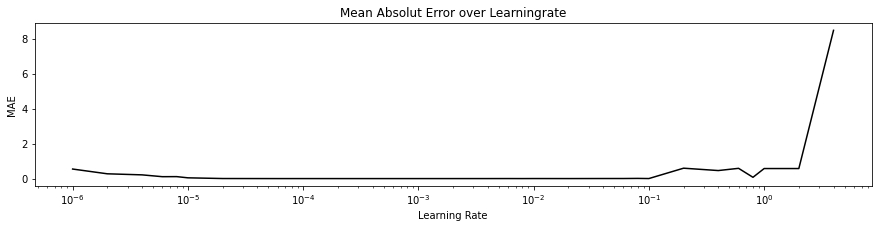

In [16]:
# skip first and last Values to get better Plot
skip_begin = 0
skip_end = 3

# Plot Error over Learing Rates
plt.figure(figsize=(15,3))
plt.semilogx(learning_rates[skip_begin:len(maes)-skip_end], maes[skip_begin:-skip_end], 'k')
plt.title('Mean Absolut Error over Learningrate')
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.show()

In [17]:
# select best learning rate
lr_idx = [i for i, mae in enumerate(maes) if mae==min(maes)][0]
LEARNING_RATE = learning_rates[lr_idx]
print('BEST LEARNING RATE FOUND:', LEARNING_RATE)

#LEARNING_RATE = 0.0004

BEST LEARNING RATE FOUND: 0.001


### 6. Learning with optimal Learining Rate

In [18]:
# build Model with defined Model Class for Training
model = Model(batch_size=BATCH_SIZE_TRAIN)

# Compile the model
Compile_Model(model)

# Run training step through network
history = model.fit( input_train, true_output_train,
                        validation_data=(input_val, true_output_val),
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE_TRAIN, 
                        shuffle=True,
                        callbacks=[early_stop_and_restore_weights],
                        verbose=2)

Epoch 1/1000
9/9 - 0s - loss: 0.1413 - mae: 0.3153 - val_loss: 0.0873 - val_mae: 0.2593
Epoch 2/1000
9/9 - 0s - loss: 0.0642 - mae: 0.2153 - val_loss: 0.0573 - val_mae: 0.2040
Epoch 3/1000
9/9 - 0s - loss: 0.0405 - mae: 0.1629 - val_loss: 0.0400 - val_mae: 0.1551
Epoch 4/1000
9/9 - 0s - loss: 0.0319 - mae: 0.1371 - val_loss: 0.0312 - val_mae: 0.1282
Epoch 5/1000
9/9 - 0s - loss: 0.0261 - mae: 0.1216 - val_loss: 0.0275 - val_mae: 0.1200
Epoch 6/1000
9/9 - 0s - loss: 0.0216 - mae: 0.1047 - val_loss: 0.0243 - val_mae: 0.1140
Epoch 7/1000
9/9 - 0s - loss: 0.0178 - mae: 0.0932 - val_loss: 0.0203 - val_mae: 0.1053
Epoch 8/1000
9/9 - 0s - loss: 0.0145 - mae: 0.0840 - val_loss: 0.0157 - val_mae: 0.0918
Epoch 9/1000
9/9 - 0s - loss: 0.0116 - mae: 0.0746 - val_loss: 0.0120 - val_mae: 0.0786
Epoch 10/1000
9/9 - 0s - loss: 0.0090 - mae: 0.0656 - val_loss: 0.0090 - val_mae: 0.0683
Epoch 11/1000
9/9 - 0s - loss: 0.0070 - mae: 0.0583 - val_loss: 0.0065 - val_mae: 0.0584
Epoch 12/1000
9/9 - 0s - loss:

### 7. Fix Model Input Size for Inference and Show model summary

In [19]:
# Build model again with batch size for inference
model_inference = Model(batch_size=BATCH_SIZE_INFERENCE)

# Set the trained weight for the new model
model_inference.set_weights(model.get_weights())

# Save model as Keras and tf model
model_inference.save(MODEL_KERAS, save_format="h5")
model_inference.save(MODEL_TF, save_format="tf")

# show Model summary
model_inference.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (1, 32)                   0         
_________________________________________________________________
dense_111 (Dense)            (1, 32)                   1056      
_________________________________________________________________
dense_112 (Dense)            (1, 32)                   1056      
_________________________________________________________________
dense_113 (Dense)            (1, 1)                    33        
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


### 8. Plot Metrics

#### 8.1 Plot Loss


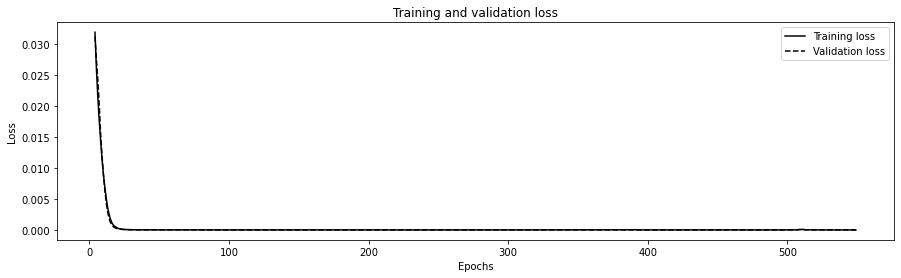

In [20]:
# Training Data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot
SKIP = 3
plt.figure(figsize=(15,4))
plt.plot(np.arange(1, len(val_loss)+1, len(val_loss)/len(train_loss))[SKIP:], train_loss[SKIP:], 'k', label='Training loss')
plt.plot(np.arange(1, len(val_loss)+1)[SKIP:], val_loss[SKIP:], 'k--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 8.2 Predict output for all datasets and get Error

In [21]:
# Make predictions based on all datasets
pred_values_train_tf = model_inference(input_train_inf)
pred_values_val_tf = model_inference(input_val_inf)
pred_values_test_tf = model_inference(input_test_inf)

# Calculate mae for all datasets
mae = tf.keras.metrics.mean_absolute_error
train_mae = mae(np.squeeze(pred_values_train_tf), np.squeeze(true_output_train_inf)).numpy()*VALUES_RANGE
val_mae = mae(np.squeeze(pred_values_val_tf), np.squeeze(true_output_val_inf)).numpy()*VALUES_RANGE
test_mae = mae(np.squeeze(pred_values_test_tf), np.squeeze(true_output_test_inf)).numpy()*VALUES_RANGE

# Print maes
print(f'TRAIN MAE: {round((train_mae),3)} ~ {round(100*train_mae/VALUES_RANGE,3)} %')
print(f'VALIDATION MAE: {round((val_mae),3)} ~ {round(100*val_mae/VALUES_RANGE,3)} %')
print(f'TEST MAE: {round((test_mae),3)} ~ {round(100*test_mae/VALUES_RANGE,3)} %')

TRAIN MAE: 0.001 ~ 0.074 %
VALIDATION MAE: 0.002 ~ 0.086 %
TEST MAE: 0.002 ~ 0.084 %


#### 8.3 Plot predictions

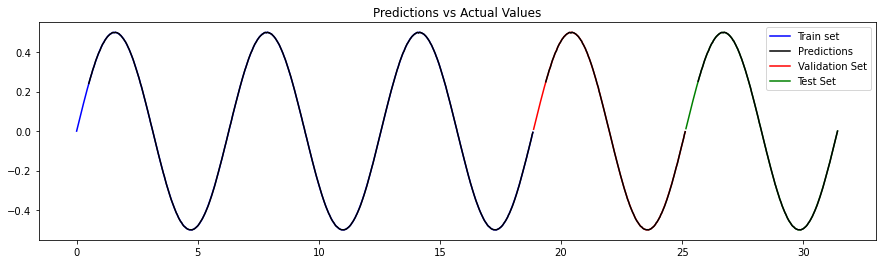

In [22]:
# Graph the predictions against the actual values
plt.figure(figsize=(15,4))

plt.title('Predictions vs Actual Values')

plt.plot(time_train, true_values_train, 'b', label='Train set')
plt.plot(time_train[WINDOW_SIZE:len(pred_values_train_tf)+WINDOW_SIZE], pred_values_train_tf, 'k', label='Predictions')
plt.plot(time_validate, true_values_validate, 'r', label='Validation Set')
plt.plot(time_validate[WINDOW_SIZE:len(pred_values_val_tf)+WINDOW_SIZE], pred_values_val_tf, 'k')
plt.plot(time_test, true_values_test, 'g', label='Test Set')
plt.plot(time_test[WINDOW_SIZE:len(pred_values_test_tf)+WINDOW_SIZE], pred_values_test_tf, 'k')

plt.legend()
plt.show()

## Generate and Train quantization aware Model

### 1. Train quantization aware model

In [23]:
# Make model quant aware
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

# `tfmot.quantization.keras.quantize_model` requires a recompile.
Compile_Model(quant_aware_model)

# Train the quantization aware model
history_quant = quant_aware_model.fit( input_train, true_output_train,
                        validation_data=(input_val, true_output_val),
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE_TRAIN, 
                        shuffle=True,
                        callbacks=[early_stop_and_restore_weights],
                        verbose=2)

Epoch 1/1000
9/9 - 1s - loss: 9.1918e-04 - mae: 0.0247 - val_loss: 9.3031e-04 - val_mae: 0.0243
Epoch 2/1000
9/9 - 0s - loss: 7.9894e-04 - mae: 0.0226 - val_loss: 4.5087e-04 - val_mae: 0.0173
Epoch 3/1000
9/9 - 0s - loss: 7.6181e-04 - mae: 0.0224 - val_loss: 6.9916e-04 - val_mae: 0.0209
Epoch 4/1000
9/9 - 0s - loss: 6.7114e-04 - mae: 0.0203 - val_loss: 6.1820e-04 - val_mae: 0.0195
Epoch 5/1000
9/9 - 0s - loss: 6.3006e-04 - mae: 0.0194 - val_loss: 6.2605e-04 - val_mae: 0.0200
Epoch 6/1000
9/9 - 0s - loss: 5.9943e-04 - mae: 0.0191 - val_loss: 6.9881e-04 - val_mae: 0.0213
Epoch 7/1000
9/9 - 0s - loss: 5.6672e-04 - mae: 0.0188 - val_loss: 5.8894e-04 - val_mae: 0.0192
Epoch 8/1000
9/9 - 0s - loss: 5.1215e-04 - mae: 0.0184 - val_loss: 6.2680e-04 - val_mae: 0.0209
Epoch 9/1000
9/9 - 0s - loss: 5.7198e-04 - mae: 0.0193 - val_loss: 6.6159e-04 - val_mae: 0.0201
Epoch 10/1000
9/9 - 0s - loss: 5.3755e-04 - mae: 0.0186 - val_loss: 5.0369e-04 - val_mae: 0.0184
Epoch 11/1000
9/9 - 0s - loss: 5.1778e-

### 2. Fix Model Input Size for Inference and show summary

In [24]:
# Make inference model quantization aware
quant_aware_model_inference = tfmot.quantization.keras.quantize_model(model_inference)

# Set the weights trained with quantization aware model
quant_aware_model_inference.set_weights(quant_aware_model.get_weights())

# Save model as Keras and tf model
quant_aware_model_inference.save(MODEL_KERAS_QUANT, save_format="h5")
quant_aware_model_inference.save(MODEL_TF_QUANT, save_format="tf")

# show Model summary
quant_aware_model_inference.summary()

INFO:tensorflow:Assets written to: models/time_series_model_ann_quant\assets


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (1, 16, 2)                3         
_________________________________________________________________
quant_flatten_37 (QuantizeWr (1, 32)                   1         
_________________________________________________________________
quant_dense_111 (QuantizeWra (1, 32)                   1061      
_________________________________________________________________
quant_dense_112 (QuantizeWra (1, 32)                   1061      
_________________________________________________________________
quant_dense_113 (QuantizeWra (1, 1)                    38        
Total params: 2,164
Trainable params: 2,145
Non-trainable params: 19
_________________________________________________________________


### 3. Plot Metrics

#### 3.1 Plot Loss

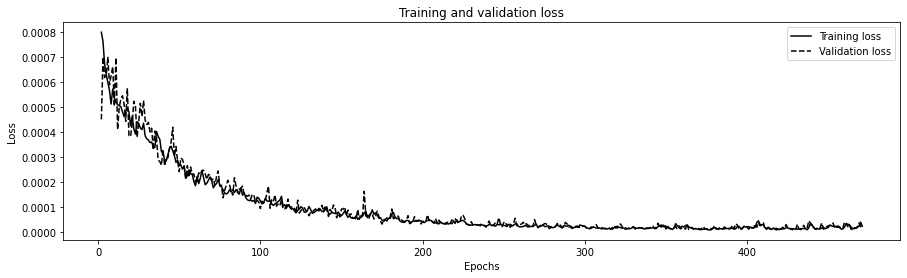

In [25]:
# Training Data
train_loss_quant = history_quant.history['loss']
val_loss_quant = history_quant.history['val_loss']

# plot
SKIP = 1
plt.figure(figsize=(15,4))
plt.plot(np.arange(1, len(val_loss_quant)+1, len(val_loss_quant)/len(train_loss_quant))[SKIP:], train_loss_quant[SKIP:], 'k', label='Training loss')
plt.plot(np.arange(1, len(val_loss_quant)+1)[SKIP:], val_loss_quant[SKIP:], 'k--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 3.2 Predict Output for all Datasets and get Error

In [26]:
# Make predictions based on all datasets
pred_values_train_quant = quant_aware_model_inference(input_train_inf)
pred_values_val_quant = quant_aware_model_inference(input_val_inf)
pred_values_test_quant = quant_aware_model_inference(input_test_inf)

# Calculate mae for all datasets
train_mae_quant = mae(np.squeeze(pred_values_train_quant), np.squeeze(true_output_train_inf)).numpy()*VALUES_RANGE
val_mae_quant = mae(np.squeeze(pred_values_val_quant), np.squeeze(true_output_val_inf)).numpy()*VALUES_RANGE
test_mae_quant = mae(np.squeeze(pred_values_test_quant), np.squeeze(true_output_test_inf)).numpy()*VALUES_RANGE

# Print maes
print(f'TRAIN MAE: {round((train_mae_quant),3)} ~ {round(100*train_mae_quant/VALUES_RANGE,3)} %')
print(f'VALIDATION MAE: {round((val_mae_quant),3)} ~ {round(100*val_mae_quant/VALUES_RANGE,3)} %')
print(f'TEST MAE: {round((test_mae_quant),3)} ~ {round(100*test_mae_quant/VALUES_RANGE,3)} %')

TRAIN MAE: 0.005 ~ 0.253 %
VALIDATION MAE: 0.005 ~ 0.265 %
TEST MAE: 0.006 ~ 0.29 %


#### 3.3 Plot Predictions

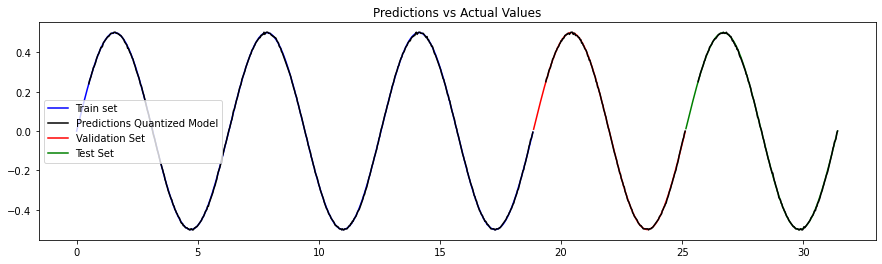

In [27]:
# Graph the predictions against the actual values
plt.figure(figsize=(15,4))

plt.title('Predictions vs Actual Values')

plt.plot(time_train, true_values_train, 'b', label='Train set')
plt.plot(time_train[WINDOW_SIZE:len(pred_values_train_quant)+WINDOW_SIZE], pred_values_train_quant, 'k', label='Predictions Quantized Model')
plt.plot(time_validate, true_values_validate, 'r', label='Validation Set')
plt.plot(time_validate[WINDOW_SIZE:len(pred_values_val_quant)+WINDOW_SIZE], pred_values_val_quant, 'k')
plt.plot(time_test, true_values_test, 'g', label='Test Set')
plt.plot(time_test[WINDOW_SIZE:len(pred_values_test_quant)+WINDOW_SIZE], pred_values_test_quant, 'k')

plt.legend()
plt.show()


## Generate a TensorFlow Lite Model

### 1. Generate TF Lite Model

In [28]:
# Init converter
converter_quant = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model_inference)
converter = tf.lite.TFLiteConverter.from_keras_model(model_inference)

# Set Optimizations
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Code for post trainig quantization of none quantization awar model
# # Create representative input dataset generator
# def representative_dataset_gen():
#   dataset = tf.data.Dataset.from_tensor_slices(input_val_inf.astype(np.float32))
#   for data in dataset:
#     yield [data]

# # Set rep dataset
# converter.representative_dataset = representative_dataset_gen

# # Set int8 as target format
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert and save the tf lite model
model_tflite_quant = converter_quant.convert()
model_tflite = converter.convert()
open(MODEL_TFLITE_QUANT, "wb").write(model_tflite_quant)
open(MODEL_TFLITE, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\robin\AppData\Local\Temp\tmplc23tgj2\assets
INFO:tensorflow:Assets written to: C:\Users\robin\AppData\Local\Temp\tmpmgchgn8u\assets


4496

### 2. Compare Model Performance

**1. Define Functin for Inference**

In [29]:
def predict_tflite(tflite_model, input):
  #  Load Test Data
  input_data = input.astype('float32')
  input_shape = (1, input_data.shape[1], input_data.shape[2])
  
  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.resize_tensor_input(0, input_shape);
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]["index"]
  output_details = interpreter.get_output_details()[0]["index"]
  
  # Invoke the interpreter
  predictions = []
  for input_datapoint in input_data:
    interpreter.set_tensor(input_details, [input_datapoint])
    interpreter.invoke()
    output = interpreter.tensor(output_details)
    predictions.append(output()[0])

  return predictions

**2. Predictions**

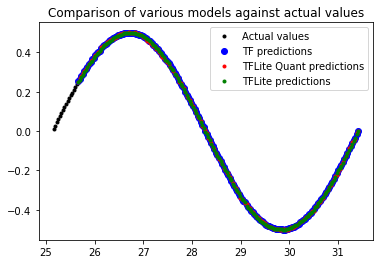

In [30]:
# Calculate predictions
pred_values_test_tflite_quant = [predict_tflite(model_tflite_quant, np.expand_dims(input_sequence, axis=0)) for input_sequence in input_test_inf]
pred_values_test_tflite_quant = np.squeeze(pred_values_test_tflite_quant)
pred_values_test_tflite = [predict_tflite(model_tflite, np.expand_dims(input_sequence, axis=0)) for input_sequence in input_test_inf]
pred_values_test_tflite = np.squeeze(pred_values_test_tflite)

# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(time_test, true_values_test, 'k.', label='Actual values')
plt.plot(time_test[WINDOW_SIZE:len(pred_values_test_tf)+WINDOW_SIZE], pred_values_test_tf, 'bo', label='TF predictions')
plt.plot(time_test[WINDOW_SIZE:], pred_values_test_tflite_quant, 'r.', label='TFLite Quant predictions')
plt.plot(time_test[WINDOW_SIZE:], pred_values_test_tflite, 'g.', label='TFLite predictions')
plt.legend()
plt.show()

**2. Loss (MAE/Mean Absolut Error)**

In [31]:
# Get mae of tflite model on train set
mae_tflite_quant = mae(np.squeeze(true_output_test_inf), pred_values_test_tflite_quant).numpy()*VALUES_RANGE
mae_tflite = mae(np.squeeze(true_output_test_inf), pred_values_test_tflite).numpy()*VALUES_RANGE

# Compare MAE
print('MAE BASE:', round((test_mae),3),'~',round(100*test_mae/VALUES_RANGE,3),'%')
print(f'MAE QUANT AWARE: {round((test_mae_quant),3)} ~ {round(100*test_mae_quant/VALUES_RANGE,3)} %')
print('MAE TF LITE:', round((mae_tflite),3),'~',round(100*mae_tflite/VALUES_RANGE,3),'%')
print('MAE TF LITE QUANT:', round((mae_tflite_quant),3),'~',round(100*mae_tflite_quant/VALUES_RANGE,3),'%')

MAE BASE: 0.002 ~ 0.084 %
MAE QUANT AWARE: 0.006 ~ 0.29 %
MAE TF LITE: 0.004 ~ 0.218 %
MAE TF LITE QUANT: 0.006 ~ 0.293 %


## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [32]:
# Convert Model to C
source_text_quant, _ = convert_bytes_to_c_source(model_tflite_quant, "model")
source_text, _ = convert_bytes_to_c_source(model_tflite, "model")

# Save C File as Header
with  open(MODEL_TFLITE_HEADER_QUANT,  'w')  as  file:
    file.write('#ifndef MODEL_DATA_H\n#define MODEL_DATA_H\n\n'+source_text_quant+'\n\n#endif //MODEL_DATA_H')

with  open(MODEL_TFLITE_HEADER,  'w')  as  file:
    file.write('#ifndef MODEL_DATA_H\n#define MODEL_DATA_H\n\n'+source_text+'\n\n#endif //MODEL_DATA_H')

    